In [1]:
# !pip install torchvision==0.13.0

0.13.0+cu102


In [1]:
from models.efficientnet import EfficientNet

from data.dataset import create_dataloader
from data.transform import get_train_transform, get_validation_transform

from losses.poly_loss import PolyLoss
from utils.plots import plot_stats, plot_roc_curve
from train import train, validate, predict

import torch
from torch import optim

import numpy as np
from sklearn.metrics import classification_report

import os

In [ ]:
# Prepare dataset
# !unzip "../data/classification_dataset.zip" -d "../data/classification_dataset/"

# Dataloaders

In [2]:
train_data_dir = "../data/classification_dataset/classification_dataset/train" # "dataset/train"
val_data_dir = "../data/classification_dataset/classification_dataset/val" # "dataset/validation"
# test_data_dir = "dataset/test"

image_size = (256, 256)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

batch_size = 8
num_workers = 2

In [3]:
train_dataloader = create_dataloader(data_dir = train_data_dir, 
                                     batch_size = batch_size, 
                                     image_size = image_size, 
                                     mean = mean, 
                                     std = std, 
                                     num_workers = 4, 
                                     train = True)

val_dataloader = create_dataloader(data_dir = val_data_dir, 
                                     batch_size = batch_size,
                                     image_size = image_size,
                                     mean = mean,
                                     std = std,
                                     train = False)

# test_dataloader = create_dataloader(data_dir = test_data_dir, 
#                                      batch_size = batch_size, 
#                                      image_size = image_size, 
#                                      mean = mean, 
#                                      std = std, 
#                                      train = False)

# Model

In [4]:
# training params
learning_rate = 0.001
epochs = 30 # 50

# model params
efficientnet_version = 'b5'
pretrained = True
num_classes = 2

weights_folder = "weights"
os.makedirs(weights_folder, exist_ok = True)

In [5]:
model = EfficientNet(version = efficientnet_version,
                     pretrained = pretrained,
                     num_classes = num_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

total_trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print("Trainable params:", total_trainable_params)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainable params: 28344882


In [6]:
optimizer = optim.Adam(model.parameters(),
                       lr = learning_rate)

criterion = PolyLoss(softmax=True) # nn.CrossEntropyLoss

# Train

In [7]:
history = train(epochs = epochs, 
                model = model, 
                train_dataloader = train_dataloader, 
                val_dataloader = val_dataloader, 
                optimizer = optimizer, 
                criterion = criterion, 
                device = device,
                save_folder = weights_folder)

train_loss = history["train_loss"] 
valid_loss = history["val_loss"]
train_acc = history["train_acc"]
valid_acc = history["val_acc"]

 50%|█████     | 15/30 [1:51:13<1:49:27, 437.85s/it]

train loss: 0.3672, val loss: 0.2855
train acc: 0.9129, val acc: 0.9277
Saving model at epoch: 1
Saving model at epoch: 1
train loss: 0.2277, val loss: 0.2107
train acc: 0.9492, val acc: 0.9635
Saving model at epoch: 2
Saving model at epoch: 2
train loss: 0.1549, val loss: 0.1157
train acc: 0.9653, val acc: 0.9825
Saving model at epoch: 3
Saving model at epoch: 3
train loss: 0.1634, val loss: 0.1276
train acc: 0.9625, val acc: 0.9712
train loss: 0.1173, val loss: 0.0801
train acc: 0.9715, val acc: 0.9796
Saving model at epoch: 5
train loss: 0.1394, val loss: 0.0456
train acc: 0.9671, val acc: 0.9895
Saving model at epoch: 6
Saving model at epoch: 6
train loss: 0.0962, val loss: 0.0581
train acc: 0.9779, val acc: 0.9846
train loss: 0.0940, val loss: 0.0680
train acc: 0.9768, val acc: 0.9832
train loss: 0.1149, val loss: 0.0451
train acc: 0.9736, val acc: 0.9895
Saving model at epoch: 9
train loss: 0.0869, val loss: 0.0548
train acc: 0.9788, val acc: 0.9888
train loss: 0.0941, val loss: 

### Plot train / val metrics

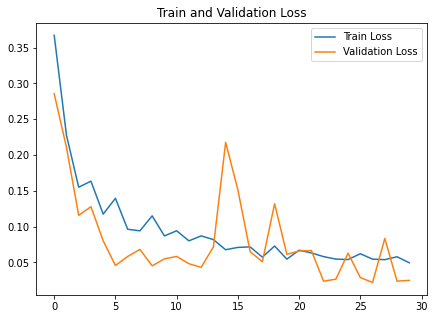

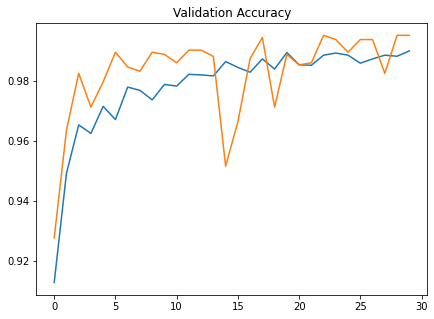

In [8]:
plot_stats(range(epochs), train_loss, valid_loss, train_acc, valid_acc)

### ROC curve

100%|██████████| 179/179 [00:37<00:00,  4.77it/s]


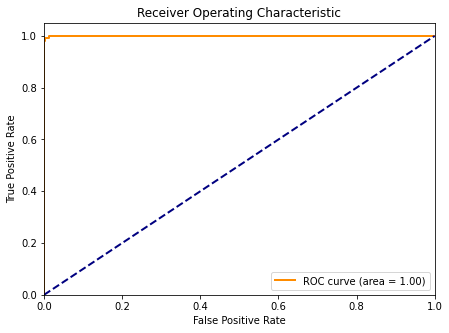

In [19]:

# for test set
# preds, gts = predict(model, test_dataloader, device, return_probs = True)

# for val set
# predict
preds, gts = predict(model, val_dataloader, device, return_probs = True)
preds, gts = np.array(preds), np.array(gts)

# plot ROC curve
# plot_roc_curve(gts, preds[:,0], pos_label = 0)
plot_roc_curve(gts, preds[:,1], pos_label = 1)

### Confusion matrix

In [11]:
# print index to class map

print(val_dataloader.dataset.class_to_idx)

{'not_school': 0, 'school': 1}


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(gts, 
                                        np.argmax(preds, axis = 1), 
                                        display_labels = ['not_school', 'school'])

### Classification report

In [20]:
print(classification_report(gts, 
                            np.argmax(preds, axis = 1), 
                            target_names=['not_school', 'school'], 
                            digits=3))

              precision    recall  f1-score   support

  not_school      0.997     0.996     0.996       927
      school      0.992     0.994     0.993       498

    accuracy                          0.995      1425
   macro avg      0.994     0.995     0.995      1425
weighted avg      0.995     0.995     0.995      1425



# Load trained model

In [ ]:
model = EfficientNet(version = 'b5',
                             pretrained = True,
                             num_classes = 2)

checkpoint = torch.load('weights/best_model_on_val_loss.pth')
model.load_state_dict(checkpoint['model'])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

### Validate

In [ ]:
loss, acc = validate(model, test_dataloader, criterion, device)

print('Accuracy: {:.4f}'.format(acc)) 
print('Loss: {:.4f}'.format(loss))

### ROC curve

In [ ]:
# predict
preds, gts = predict(model, test_dataloader, device, return_probs = True)
preds, gts = np.array(preds), np.array(gts)

# plot ROC curve
plot_roc_curve(gts, preds[:,0], pos_label = 0)

### Confusion matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(gts, 
                                        np.argmax(preds, axis = 1), 
                                        display_labels = ['cell', 'no_cell'])

### Classification report

In [ ]:
print(classification_report(gts, 
                            np.argmax(preds, axis = 1), 
                            target_names=['cell', 'no_cell'], 
                            digits=3))